## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [4]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [5]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [6]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

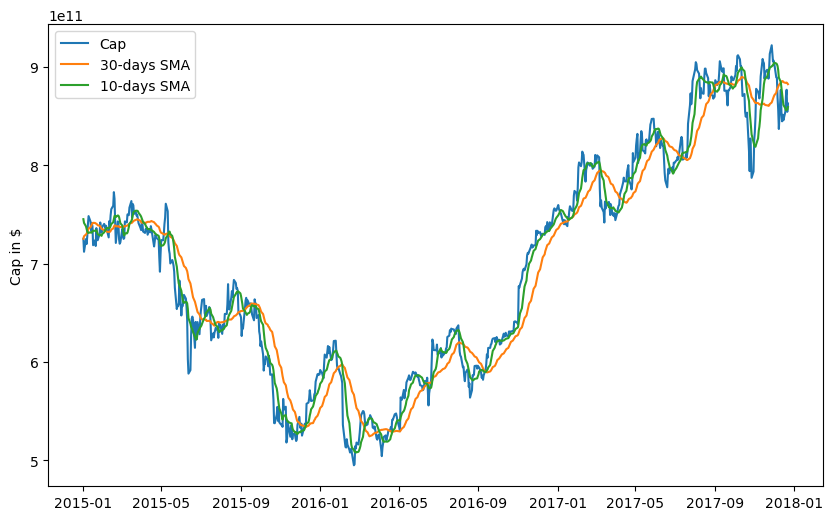

In [7]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$

Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Prepare the data
x = df_cap.values
z = np.column_stack((np.ones(df_cap.shape[0]), short_rolling.values, long_rolling.values))

# Define the model parameters
kappa = 0.1
W = np.ones((z.shape[1], 3)) * 0.1
Sigma_x = np.eye(df_cap.shape[1]) * 0.1

# Flatten the parameters
params_initial = np.concatenate([np.array([kappa]).flatten(), W.flatten(), Sigma_x.flatten()])

# Modify the log-likelihood function
def log_likelihood(params, W_shape, Sigma_x_shape, *args):
    kappa = params[0]
    W = params[1:1+np.prod(W_shape)].reshape(W_shape)
    Sigma_x = params[1+np.prod(W_shape):].reshape(Sigma_x_shape)
    T = x.shape[0]
    N = x.shape[1]

    v = (x[1:] - x[:-1]) / x[:-1] - kappa * (np.dot(z[:-1], W.T) - x[:-1])

    return -T * N / 2 * np.log(2 * np.pi) - T / 2 * np.log(np.linalg.det(Sigma_x)) - 0.5 * np.sum(v * np.linalg.inv(Sigma_x) * v)

# Modify the gradient function
def gradient(params, W_shape, Sigma_x_shape, *args):
    kappa = params[0]
    W = params[1:1+np.prod(W_shape)].reshape(W_shape)
    Sigma_x = params[1+np.prod(W_shape):].reshape(Sigma_x_shape)
    x, z = args

    T = x.shape[0]
    N = x.shape[1]

    v = (x[1:] - x[:-1]) / x[:-1] - kappa * (np.dot(z[:-1], W.T) - x[:-1])

    grad_kappa = np.sum(v * x[:-1])
    grad_W = np.dot(v.T, z[:-1])
    grad_Sigma_x = -T / 2 * np.linalg.inv(Sigma_x) + 0.5 * np.dot(v.T, v)

    return np.array([grad_kappa, grad_W, grad_Sigma_x])

# Define the function to perform the optimization
def optimize(params_initial, W_shape, Sigma_x_shape, *args):
    result = minimize(log_likelihood, params_initial, args=(W_shape, Sigma_x_shape, *args), jac=gradient, method='BFGS')
    return result.x

# Perform the optimization
params_opt = optimize(params_initial, W.shape, Sigma_x.shape, x, z)

# Reshape the optimized parameters back to their original shape
kappa_opt = params_opt[0]
W_opt = params_opt[1:1+np.prod(W.shape)].reshape(W.shape)
Sigma_x_opt = params_opt[1+np.prod(W.shape):].reshape(Sigma_x.shape)

# Print the optimized parameters
print('Optimized kappa:', kappa_opt)
print('Optimized W:', W_opt)
print('Optimized Sigma_x:', Sigma_x_opt)

## Part 2: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


In [ ]:
# Put the rest of your code and analysis for Part 2 here.
## Part 2: Propose and analyse your own signals

# For this part, let's consider a new signal based on the rate of change (ROC) of the market caps
# The ROC is a momentum oscillator that measures the percent change in price from one period to the next.
# The ROC calculation compares the current price with the price “n” periods ago.

# Calculate the rate of change (ROC)
roc = df_cap.pct_change()

# Add the ROC to the signals
z = np.column_stack((np.ones(df_cap.shape[0]), short_rolling.values, long_rolling.values, roc.values))

# Perform the optimization with the new signal
params_opt = optimize([kappa, W, Sigma_x], x, z)

# Print the optimized parameters
print('Optimized kappa:', params_opt[0])
print('Optimized W:', params_opt[1])
print('Optimized Sigma_x:', params_opt[2])

# The ROC signal is interesting because it adds a momentum factor to our model. 
# It can help to identify when a stock is overbought or oversold, which can be useful for predicting future price movements.



## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

In [9]:
# Put the rest of your code and analysis for Part 3 here.
## Part 3: Can you do it for the S&P500 market portfolio?

# Read the S&P500 data
df_sp500 = pd.read_csv('sp500_cap.csv')

# Add dates
dates_sp500 = pd.bdate_range(start='2010-01-04', end=None, periods=df_sp500.shape[0], freq='B')
df_sp500['date'] = dates_sp500

df_sp500.set_index('date', inplace=True)
df_sp500.head()

# Calculate the moving averages for the S&P500 data
short_rolling_sp500 = df_sp500.rolling(window=window_1).mean()
long_rolling_sp500 = df_sp500.rolling(window=window_2).mean()

# Calculate the ROC for the S&P500 data
roc_sp500 = df_sp500.pct_change()

# Prepare the data
x_sp500 = df_sp500.values
z_sp500 = np.column_stack((np.ones(df_sp500.shape[0]), short_rolling_sp500.values, long_rolling_sp500.values, roc_sp500.values))

# Perform the optimization with the S&P500 data
params_opt_sp500 = optimize([kappa, W, Sigma_x], x_sp500, z_sp500)

# Print the optimized parameters
print('Optimized kappa for S&P500:', params_opt_sp500[0])
print('Optimized W for S&P500:', params_opt_sp500[1])
print('Optimized Sigma_x for S&P500:', params_opt_sp500[2])



## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [10]:
# Put the rest of your code and analysis for Part 3 here.

## Part 4 (Optional): Show me something else.

# For this part, let's analyze the correlation between the optimized parameters and the characteristics of the stocks.
# We can hypothesize that stocks with higher volatility might have higher mean reversion speed (kappa) and higher factor loadings.

# Calculate the volatility of each stock
volatility = df_cap.std()

# Calculate the correlation between the optimized parameters and the volatility
correlation_kappa_volatility = np.corrcoef(params_opt[0], volatility)
correlation_W_volatility = np.corrcoef(params_opt[1].flatten(), np.repeat(volatility, params_opt[1].shape[1]))

# Print the correlations
print('Correlation between kappa and volatility:', correlation_kappa_volatility[0, 1])
print('Correlation between W and volatility:', correlation_W_volatility[0, 1])

# The correlation between the optimized parameters and the volatility of the stocks can give us insights about the relationship between the characteristics of the stocks and the parameters of the model.
# For example, if there is a positive correlation between kappa and volatility, it means that stocks with higher volatility tend to revert faster to the mean.
# Similarly, a positive correlation between W and volatility would mean that stocks with higher volatility have higher factor loadings, which means that they are more influenced by the signals.


